# `hetGPy` Intro: Background and Basic Usage

* This notebook gives a high-level overview of the basics of `hetGPy`
* We discuss the core model objects, regression, and prediction

This document assumes some prior knowledge of Gaussian Process modeling. For those looking for a refresher, some suggested sources are [Ch.2 of Rassmussen and Williams (2006)](https://gaussianprocess.org/gpml/), [Ch. 5 of Gramacy (2020)](https://bookdown.org/rbg/surrogates/#front-cover), and [Ch. 2-3 of Garnett (2023)](https://bayesoptbook.com/).


### What is `hetGPy`?

`hetGPy` is a Python library for homoskedastic and heteroskedastic Gaussian Process modeling. It is a Python port of the `hetGP` R package from [Binois and Gramacy (2018)](https://cran.r-project.org/web/packages/hetGP/index.html). The package also includes functions for sequential design and Bayesian Optimization.


### Why is a Python port needed when we have `rpy2` to call R code from Python?

For the basic use cases of Gaussian Process modeling, most of the time you can wrap the R code from `hetGP` via the [rpy2](https://rpy2.github.io/) Python library. However, there are three principle motivations for having a Python port:

1. **Environment restrictions and sequential design:**
    
    Gaussian Process modeling is especially useful for computer experiments and Bayesian Optimization. In both domains, it is common to work with expensive simulation functions which are run on high-performance computing clusters, and many of these simulators are written in Python. Thus, when working on computing clusters, it is advantageous to use one type of software rather than trying to build multiple computing environments. Additionally, in `rpy2` the R objects live in R's memory space, and their size is [unknown to Python](https://rpy2.github.io/doc/latest/html/performances.html). For large-scale analyses, this could prove problematic.

   In many cases, computer experiments and Bayesian Optimization rely on sequential design: initialzing some set of inputs, acquiring (usually expensive) data, and then choosing the next set of experiments via some criteria or acquisition function. Thus, keeping the entire analysis in one language (in this case, Python) is desirable for human-out-of-the-loop workflows.


2. **Opportunity for extensions:** 
    
    The core maximum likelihood routines in `hetGP` and `hetGPy` rely on hand-coded likelihoods and gradients, and are thus restricted to a subset of closed-form covariance kernels (in this case, Gaussian and Matern kernels ($\nu = 3/2, 5/2$)). State of the art Python libraries, such as [pytorch](https://pytorch.org/) and [jax](https://jax.readthedocs.io/en/latest/index.html) utilize autodifferentiation methods, which would allow for a more flexible use of arbitrary covariance kernels in `hetGPy`.

3. **Availability of high-performance optimization functions:**
    
    Most of the computation in `hetGPy` is the optimization of the maximum likelihood which relies on the [L-BFGS-B](https://en.wikipedia.org/wiki/Limited-memory_BFGS#Variants#L-BFBS-B) algorithm, a standard constrained optimization routine. The definitive [L-BFGS-B](https://en.wikipedia.org/wiki/Limited-memory_BFGS#Variants#L-BFBS-B) implementation is by [Nocedal and Morales (2011)](https://dl.acm.org/doi/10.1145/2049662.2049669) in Fortran, which is callable from [scipy](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) but [not from base R](https://nlmixrdevelopment.github.io/lbfgsb3c/articles/lbfgsb3c.html). 


###  Basic Setup

* The central objects that performs Gaussian process regeression (GPR) in `hetGPy` are the `homGP` and `hetGP` classes for homoskedastic and heteroskedasic regression.

First, we show `homGP` modeling on noiseless data, noisy data, and finally on heteroskedastic noise.

### Noiseless case

In [1]:
from hetgpy import homGP
import numpy as np
import matplotlib.pyplot as plt

xgrid = np.linspace(0,2*np.pi, 100).reshape(-1,1)
xs    = xgrid.squeeze() # for plotting

X = np.linspace(0,2*np.pi, 10).reshape(-1,1)
Z = np.sin(X).squeeze()

* To train a GPR, instantiate the model object (`homGP` or `hetGP`) and call the maximum likelihood estimation function (`mle` which aliases the functions `mleHomGP` and `mleHetGP` which are the equivalent function names in the `hetGP` R package).
* After training, call `predict` on the model object to return the mean and variance predictions. 

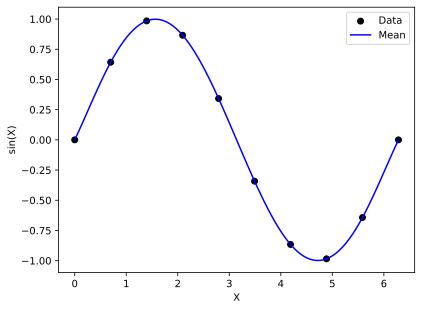

In [2]:
# now train a homoskedastic Gaussian Process Regression
%config InlineBackend.figure_formats = ['svg']
fig, ax = plt.subplots()
ax.scatter(X, Z, color = 'k', label = 'Data')
ax.legend(edgecolor='black')
ax.set_xlabel('X'); ax.set_ylabel('sin(X)')

GP = homGP()
GP.mle(
    X = X,
    Z = Z,
    covtype = "Gaussian",
    lower = np.array([0.1]),
    upper = np.array([2.0])
)
preds = GP.predict(x = xgrid)
ax.plot(xs, preds['mean'], color = 'blue', label = 'Mean')
ax.legend();

### Fast Estimation under Replication

* `hetGPy` is designed to handle replication
* Consider the same example, except this time with some replication (5 each) and noise
* Like its R counterpart, `hetGPy` does training on the order of the unique input locations $n$ rather than the full dataset $N$. When replication is high, as is common in stochastic computer experiments, this can yield much shorter training times.

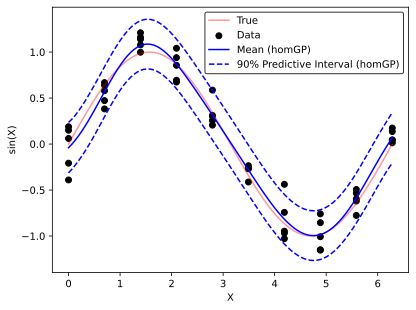

In [3]:
rand  = np.random.default_rng(seed = 42)

X  = np.linspace(0,2*np.pi, 10)
X  = np.repeat(X,repeats = 5).reshape(-1,1)
Z  = np.sin(X).squeeze() 
Z += 0.2 * rand.normal(loc = 0,size = len(Z))

fig, ax = plt.subplots()

ax.plot(xs, np.sin(xs), label = 'True', color = 'red', alpha = 0.4)
ax.scatter(X, Z, color = 'k', label = 'Data')
ax.legend(edgecolor='black')
ax.set_xlabel('X'); ax.set_ylabel('sin(X)');


GP = homGP()
GP.mle(
    X = X,
    Z = Z,
    covtype = "Gaussian",
    lower = np.array([0.1]),
    upper = np.array([2.0])
)
preds    = GP.predict(x = xgrid, interval = 'predictive', interval_lower = 0.05, interval_upper = 0.95)
interval = preds['predictive_interval']

ax.plot(xs, preds['mean'], color = 'blue', label = 'Mean (homGP)')
ax.plot(xs, interval['lower'], color = 'blue', label = '90% Predictive Interval (homGP)', linestyle = 'dashed')
ax.plot(xs, interval['upper'], color = 'blue',linestyle = 'dashed')
ax.legend(edgecolor='black');

### Heteroskedastic Gaussian Process Regression

We can also perform heteroskedastic GPR. Consider the [mcycle](https://rdrr.io/cran/MASS/man/mcycle.html) motorocycle simulation data from R (available in `hetGPy`) which is known to have heteroskedasticity.

The major advantage of a heteroskedastic approach is the improved uncertainty quantification, in that we estimate a wider predictive interval in the higher noise regions, and a narrow one in lower noise regions, especially compared to a homoskedastic model.

We model the noise as a series of latent variables at each unique input via a second (homoskedastic) GP. The model for the noise process is from [Binois and Gramacy (2018)](https://www.tandfonline.com/doi/full/10.1080/10618600.2018.1458625) and is also given in [Gramacy (2020), Ch. 10](https://bookdown.org/rbg/surrogates/chap10.html#chap10varp) (equation 10.7):

\begin{align*}
\Lambda_n =  C_{(\delta)} K_{(\delta)}^{-1} \Delta_n, \text{    where     } K_{(\delta)} =  (C_{(\delta)} + g_{(\delta)} A_n^{-1}).
\end{align*}

Where $\Lambda_n$ is the prediction of the noise, $C_{(\delta)}$ is the covariance matrix, $\Delta_n$ is the estimated variance at each input, and $A_n^{-1}$ is the inverse of the number of replicates for each input location (stored in a diagonal matrix).

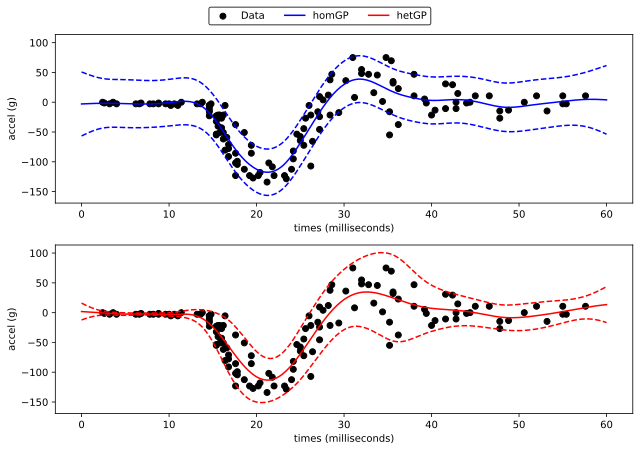

In [4]:
from hetgpy import hetGP
from hetgpy.example_data import mcycle

m = mcycle()
X = m['times']
Z = m['accel']

xgrid = np.linspace(0,60,301).reshape(-1,1) # predictive grid
xs    = xgrid.squeeze()

hom, het = homGP(), hetGP()

# homGP
hom.mle(
    X = X,
    Z = Z,
    covtype = "Matern5_2",
    lower = np.array([0.1]),
    upper = np.array([50.0])
)
preds_hom    = hom.predict(x = xgrid, interval = 'predictive', interval_lower = 0.05, interval_upper = 0.95)
interval_hom = preds_hom['predictive_interval']

# hetGP
het.mle(
    X = X,
    Z = Z,
    covtype = "Matern5_2",
    lower = np.array([0.1]),
    upper = np.array([50.0])
)
preds_het    = het.predict(x = xgrid, interval = 'predictive', interval_lower = 0.05, interval_upper = 0.95)
interval_het = preds_het['predictive_interval']


fig, ax = plt.subplots(nrows=2,figsize=(9,6),sharey=True)

ax[0].scatter(X.squeeze(),Z,label='Data',color='black')
ax[1].scatter(X.squeeze(),Z,color='black')

ax[0].plot(xs, preds_hom['mean'], color = 'blue', label = 'homGP')
ax[0].plot(xs, interval_hom['lower'], color = 'blue', linestyle = 'dashed')
ax[0].plot(xs, interval_hom['upper'], color = 'blue',linestyle = 'dashed')

ax[1].plot(xs, preds_het['mean'], color = 'red', label = 'hetGP')
ax[1].plot(xs, interval_het['lower'], color = 'red', linestyle = 'dashed')
ax[1].plot(xs, interval_het['upper'], color = 'red',linestyle = 'dashed')

fig.legend(edgecolor='black',loc='upper center',ncol=3,bbox_to_anchor=(0.5,1.05))
[ax[i].set_xlabel('times (milliseconds)') for i in range(2)];
[ax[i].set_ylabel('accel (g)') for i in range(2)];
fig.tight_layout()

### Specifying initializations for the hyperparamters
*   Specify starting values for the hyperparameters via the `init = {param:value}` argument

For example, to initialize the lengthscale $\theta$ at $\theta_0=10$:

In [5]:
GP = hetGP()
GP.mle(
    X = X,
    Z = Z,
    lower = np.array([1.0]),
    upper = np.array([10]),
    init = {'theta': np.array([10.0])}
)
print(f"Lengthscale: {GP.theta}")
print(f"Log likelihood: {GP.ll}")

Lengthscale: [9.95168406]
Log likelihood: -499.2919739824025


### Specifying known values of hyperparameters
*   You can also override the hyperparameter learning via the `known` argument

For example, to fix the lengthscale of the mean process at $\theta=3$ (and note the lower fit based on log-likelood):

In [ ]:
GP = hetGP()
GP.mle(
    X = X,
    Z = Z,
    lower = np.array([1.0]),
    upper = np.array([10]),
    known = {'theta': np.array([3.0])}
)
print(f"Lengthscale: {GP.theta}")
print(f"Log likelihood: {GP.ll}")


Lengthscale: [3.]
Log likelihood: -513.7520035600228
